# signature

In [88]:
import os
import itertools
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

In [89]:
def contrastive_loss(y_true, y_pred, margin=1.0):
    """
    y_true: labels (0 pour similaire, 1 pour dissemblable)
    y_pred: distances prédites entre les paires d'images
    margin: marge pour les paires dissemblables
    """
    # Conversion de y_true en float32 pour éviter des erreurs de type
    y_true = tf.cast(y_true, tf.float32)
    # Calcul des pertes pour les paires similaires et dissemblables
    loss_similar = (1 - y_true) * 0.5 * K.square(y_pred)
    loss_dissimilar = y_true * 0.5 * K.square(K.maximum(margin - y_pred, 0))
    return K.mean(loss_similar + loss_dissimilar)

def create_base_network(input_shape):
    input = Input(shape=input_shape)
    
    # First Convolutional Block
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Second Convolutional Block
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Third Convolutional Block
    x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    
    # Fully Connected Layers
    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    
    return Model(input, x)

input_shape = (128, 128, 1)
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Passer chaque entrée par le réseau de base
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Calculer la distance euclidienne entre les représentations des deux images
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

distance = Lambda(euclidean_distance)([processed_a, processed_b])
output = Dense(1, activation='sigmoid')(distance)
model = Model([input_a, input_b], output)

In [120]:
# Charger les poids sauvegardés
model_1 =          './models/best_model_V5.keras'
model_2 = './models/best_model_V5_continue.keras'
model.load_weights(model_2)

# Ajustement du learning rate
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
model.compile(loss=contrastive_loss, optimizer=optimizer, metrics=['accuracy'])

In [121]:
def predict_similarity(img1_path, img2_path, model):
    img1 = load_img(img1_path, target_size=(128, 128), color_mode='grayscale')
    img2 = load_img(img2_path, target_size=(128, 128), color_mode='grayscale')
    img1 = img_to_array(img1) / 255.0  # Convertir en tableau NumPy et normaliser
    img2 = img_to_array(img2) / 255.0  # Convertir en tableau NumPy et normaliser
    img1 = img1.reshape(1, 128, 128, 1)  # Redimensionner pour correspondre à l'entrée du modèle
    img2 = img2.reshape(1, 128, 128, 1)  # Redimensionner pour correspondre à l'entrée du modèle
    similarity_score = model.predict([img1, img2], verbose=0)
    return similarity_score[0][0]

def classify_similarity_label(score, threshold=0.5):
    return "similar" if score > threshold else "dissimilar"

def classify_similarity(score, threshold=0.5):
    return 1 if score > threshold else 0

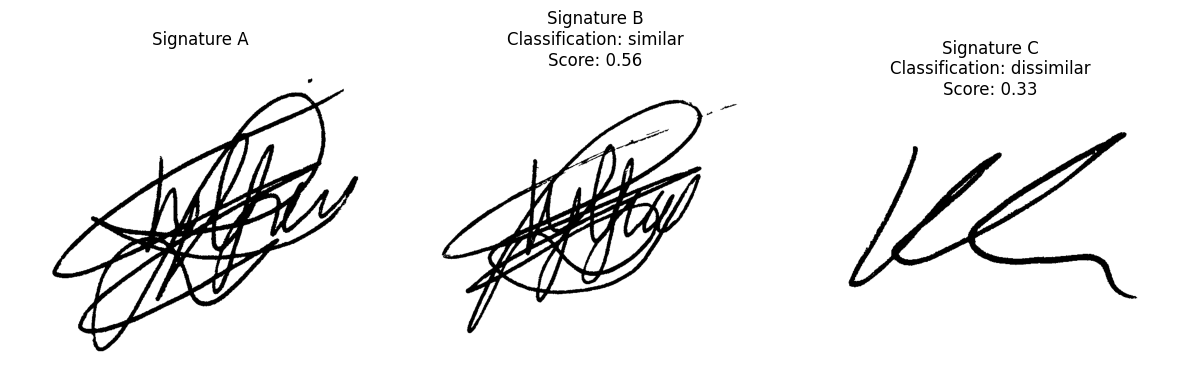

In [122]:
img1 =   "./data/genuine_signatures/person1/genuine (1).png"
img1_1 = "./data/genuine_signatures/person1/genuine (2).png"
img2 =   "./data/genuine_signatures/person3/genuine (3).png"

plt.figure(figsize=(12, 4))
# Signature A
plt.subplot(1, 3, 1)
plt.imshow(load_img(img1, color_mode='grayscale'), cmap='gray')
plt.title("Signature A")
plt.axis('off')
# Signature B
plt.subplot(1, 3, 2)
plt.imshow(load_img(img1_1, color_mode='grayscale'), cmap='gray')
score_AB = predict_similarity(img1, img1_1, model)
plt.title(f"Signature B\nClassification: {classify_similarity_label(score_AB)}\nScore: {score_AB:.2f}")
plt.axis('off')
# Signature C
plt.subplot(1, 3, 3)
plt.imshow(load_img(img2, color_mode='grayscale'), cmap='gray')
score_AC = predict_similarity(img1, img2, model)
plt.title(f"Signature C\nClassification: {classify_similarity_label(score_AC)}\nScore: {score_AC:.2f}")
plt.axis('off')

plt.tight_layout()
plt.show()

## éval global

In [123]:
import pandas as pd
df = pd.read_csv('signature_pairs.csv', sep=";")
sample_1 = df[df['label'] == 1].sample(n=250, random_state=0)
sample_0 = df[df['label'] == 0].sample(n=250, random_state=0)
df = pd.concat([sample_1, sample_0])

In [124]:
df['score'] = df.apply(lambda row: predict_similarity(row['image_1'], row['image_2'], model), axis=1)
df['prediction'] = df.apply(lambda row: classify_similarity(row['score']), axis=1)
df.head()

,image_1,image_2,label,score,prediction
981,./data/genuine_signatures/009/009_21.PNG,./data/genuine_signatures/009/009_12.PNG,1,0.154551,0
683,./data/genuine_signatures/014/014_07.PNG,./data/genuine_signatures/014/014_23.PNG,1,0.286437,0
195,./data/genuine_signatures/015/015_10.PNG,./data/genuine_signatures/015/015_01.PNG,1,0.502110,1
1158,./data/genuine_signatures/009/009_07.PNG,./data/genuine_signatures/009/009_10.PNG,1,0.485322,0
1553,./data/genuine_signatures/006/006_11.PNG,./data/genuine_signatures/006/006_05.PNG,1,0.583477,1


In [125]:
matrice_confusion = pd.crosstab(df['label'], df['prediction'], rownames=['Classe réelle'], colnames=['Classe prédite'])
matrice_confusion

Classe prédite,0,1
Classe réelle,,
0,242,8
1,108,142


In [126]:
import numpy as np

# Matrice de confusion
# Classe réelle / prédite    0     1
# 0 (réelle)               [489,  11]
# 1 (réelle)               [254, 246]

def calcul_metrices_confusion(matrice):
    """
    matrice : numpy array 2x2
        matrice[0, 0] = Vrais négatifs (TN)
        matrice[0, 1] = Faux positifs (FP)
        matrice[1, 0] = Faux négatifs (FN)
        matrice[1, 1] = Vrais positifs (TP)
    """
    TN, FP, FN, TP = matrice[0][0], matrice[0][1], matrice[1][0], matrice[1][1]
    precision = (TP + TN) / (TP + TN + FP + FN)
    precision_positive = TP / (TP + FP)
    rappel = TP / (TP + FN)
    score_f1 = 2 * (precision_positive * rappel) / (precision_positive + rappel)
    return precision, precision_positive, rappel, score_f1

# Calcul des métriques
precision, precision_positive, rappel, score_f1 = calcul_metrices_confusion(matrice_confusion)

# Affichage des résultats
print(f"Précision (Accuracy) : {precision:.3f}")
print(f"Précision positive (Precision) : {precision_positive:.3f}")
print(f"Rappel (Recall) : {rappel:.3f}")
print(f"Score F1 : {score_f1:.3f}")

Précision (Accuracy) : 0.768
Précision positive (Precision) : 0.568
Rappel (Recall) : 0.947
Score F1 : 0.710


## eval class 1

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_ke

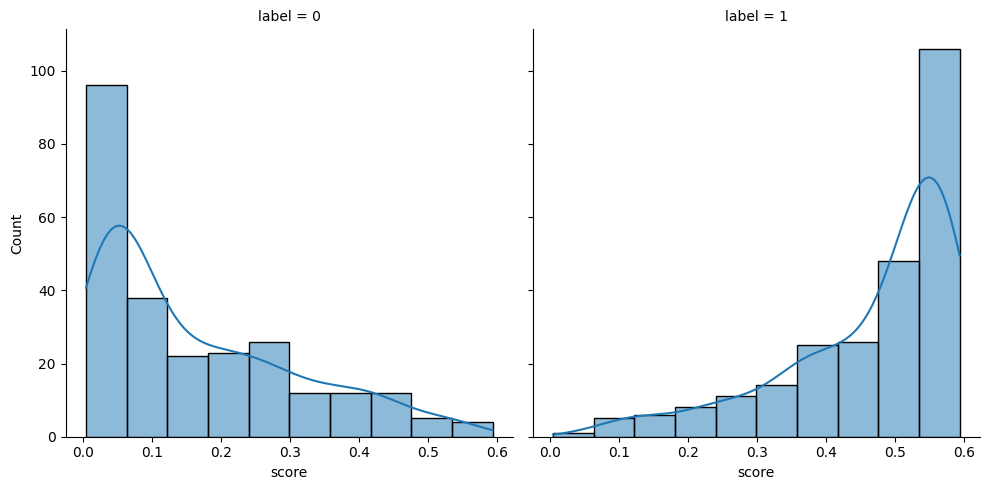

In [127]:
sns.displot(data=df, x='score', col='label', kde=True, bins=10)